## Computation of DOS of a disordered 1D semimetal

We are considering a 1D tight binding Hamiltonian with long range hoppings

$ H = \sum_{i,j} t_{i,j} c_i^\dagger c_j + \sum_i V_i c_i^\dagger c_i $ 

where $c_i, c_i^\dagger$ are annihilation and creation operatores at site $i$, $t_{i,j}$ is the hopping strength between $i$ and $j$ sites, $V_i$ is random onsite potential with normal distribution $\frac{1}{W \sqrt{2\pi}} e^{-\frac{1}{2}(\frac{x}{W})^2}$.

The kinetic part of the Hamiltonian in momentum space ($k$-space) is

$T_k = -sign(\cos(k + \theta))\vert \cos(k + \theta) \vert^\sigma $ 

### The KPM moduel 

The KPM (Kernel Polynomial Method) is a moduel to calculate the DOS. We are using the function $KPM.DensityOfStates(H, NC, NR, Ntilde; Emin, Emax)$ in our calculation, where 
 - H is the Hamiltonian matrix
 - NC is Expansion order for the KPM
 - NR is the number of random vectors for trace
 - Ntilde is the grid points for density of states
 - Emin, Emax are the range of eigenvalues
 

### To do list 

#### For ww = 0.0
 - *average* over theta
 - Do this for one size L = 100 
 - Do this for various NCs 2^8, 2^9, 2^10, 2^11, 2^12
 - plot rho(0) vs NC (log-log plot)

#### For ww > 0.0
 - *average* over theta and disorder realizations
 - Do this for various sizes L = 100 ... big number that you can handle.
 - Repeat what we did for ww = 0.0
 - ...
 - rho(0) vs ww (for your largest NC)

In [1]:
include("KPM.jl")
using .KPM
using AbstractFFTs, Random, LinearAlgebra, LaTeXStrings, Statistics, Plots

### The function generating the Hamiltonian matrices

In [2]:
## Hamiltonian definition ##
function Hamiltonian(sig,ll,th,ww; seed = 2341)
    
    tk(n,sig,ll,th)=-sign(cos(2.0*pi*n/ll+th/ll))*Float64(abs(cospi(2.0*n/ll+th/(pi*ll)))^sig); #k-space Hamiltonian Z
    
    Random.seed!(seed) #setting the seed

    Vx = ww.*randn(ll)
    
    Vxx = sum(Vx)/ll 
    
    ##################################################################################### 
    
    ############################## real sapce Hamiltonian ################################
    
    Hk = zeros(ll)   #kinetic part of k-space Hamiltonian

    for l in 1:ll
        Hk[l] = tk(l,sigma,ll,th)
    end 

    Hf = ifft(Hk)

    #Hf = ifftshift(Hf)

    H = zeros(Complex{Float64},ll,ll); 

    for i in 1:ll
        for j in 1:ll
            if i==j
                H[i,j] = Vx[i] - Vxx
            elseif i>j
                H[i,j] = Hf[i-j+1]
            else
                H[i,j] = conj(Hf[j-i+1]) 
            end
        end
    end
    
    H_r = H .- (diagm(Vx) .- Vxx)
    
    #################################################################################
    
    #################### k-space Hamiltonian ############################
    
    Vk=fft(Vx)/ll;        #Fourier transform of random potential
    #Vk=fftshift(Vk);   #moving the zero potential to the center of the spectrum 
    #Vkk=sum(Vx);       #diagonal element of V_{k,k'}

    Ham=zeros(Complex{Float64},ll,ll);          #initializing the Hamiltonian matrix with zeros
    #vecs=zeros(Complex{Float64},L,L);         #initializaing the eigenvectors with zeros 

    for i in 1:ll
        for j in 1:ll
            if i==j
               Ham[i,j]=tk(i,sigma,ll,th) #+ Vkk/L
            elseif i<j
                Ham[i,j]=Vk[j-i+1]
            else
                Ham[i,j]=conj(Vk[i-j+1])
            end
        end
    end
    
    H_k = diagm(diag(Ham))
    
    V_kspace = Ham .-diagm(diag(Ham))
    
    return (diagm(Vx).-Vxx), H_r, V_kspace, H_k, H, Ham
    
end

Hamiltonian (generic function with 1 method)

#### We start with $\sigma=0.1$ case, and first calculate $W=0$ case, then $W\neq0$ case

### W=0 case

In [3]:
##-- Parameters --##

## -- w=0 case --##
sigma = 0.1
ll = 100
#theta=pi
thetas = [-pi:pi/50:pi;]
ww = 0.0

#NC=2^9
NC = [2^8,2^9,2^10,2^11,2^12] # Expansion order for the KPM
NR = 50  # Number of random vectors for trace
#Ntilde = 2NC # Grid points for density of states 

##-- rhoE (averaged ove theta) for various NC --

rhoEnc=Array{Array{Float64}, 1}(undef, length(NC))
Evalnc=Array{Array{Float64}, 1}(undef, length(NC))

for n in 1:length(NC)

    Ntilde = 2*NC[n]

    rhoEs=zeros(length(thetas),Ntilde)
    Evals_mat = zeros(length(thetas),Ntilde)

    for i in 1:length(thetas)
    
        dummy, dummy, dummy, dummy, H, Ham = Hamiltonian(sigma, ll, thetas[i], ww)

        Eval, rhoE0 = KPM.DensityOfStates(Ham, NC[n], NR, Ntilde; Emin = -1.0, Emax = 1.0) 

        rhoEs[i,:]=rhoE0
        Evals_mat[i,:]=Eval

    end 

    rhoEnc[n]=mean(rhoEs,dims=1)
    Evalnc[n]=Evals_mat[1,:]

end

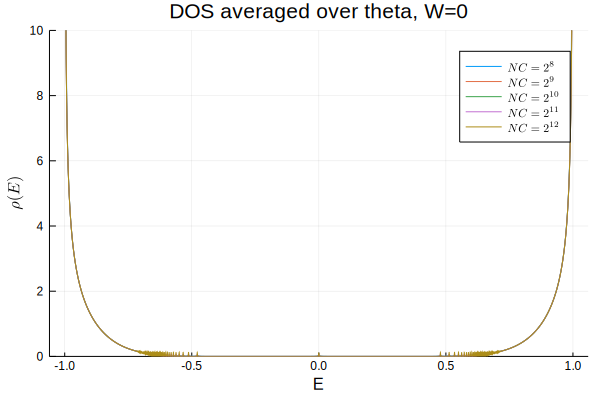

In [4]:
##-- plotting --##

plot(Evalnc[1,:][1],rhoEnc[1][1,:],ylim=(0,10),xlabel="E",ylabel=L"\rho(E)",label=L"NC=2^8",title = "DOS averaged over theta, W=0")
plot!(Evalnc[2,:][1],rhoEnc[2][1,:], ylim=(0,10),label=L"NC=2^9")
plot!(Evalnc[3,:][1],rhoEnc[3][1,:], ylim=(0,10),label=L"NC=2^{10}")
plot!(Evalnc[4,:][1],rhoEnc[4][1,:], ylim=(0,10),label=L"NC=2^{11}")
plot!(Evalnc[5,:][1],rhoEnc[5][1,:], ylim=(0,10),label=L"NC=2^{12}") 

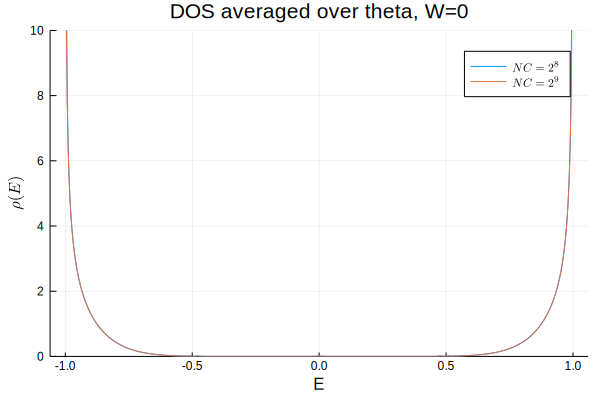

In [5]:
plot(Evalnc[1,:][1],rhoEnc[1][1,:],ylim=(0,10),xlabel="E",ylabel=L"\rho(E)",label=L"NC=2^8",title = "DOS averaged over theta, W=0")
plot!(Evalnc[2,:][1],rhoEnc[2][1,:], ylim=(0,10),label=L"NC=2^9")

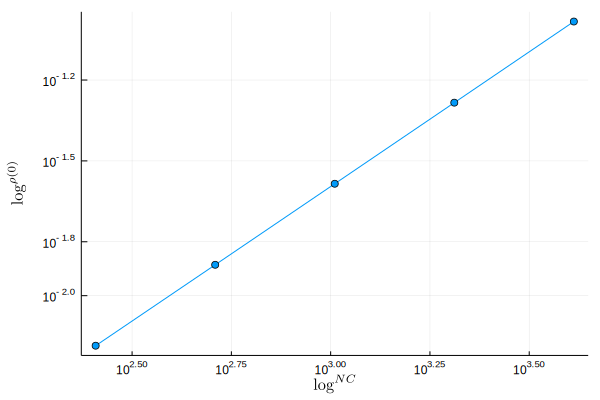

In [8]:
##-- rhoE(0) vs NC --
rhoE0s=zeros(length(NC))
for i in 1:length(NC)
    rhoE0s[i]=rhoEnc[i][1,:][findall(x->x==minimum(abs.(Evalnc[i,:][1])),Evalnc[i,:][1])[1]]
end

plot(NC,rhoE0s, xaxis=:log,yaxis=:log,xlabel=L"\log^{NC}",ylabel=L"\log^{\rho(0)}",label=:false,shape=:circle)

### $W\neq0$ case

In [9]:
##-- Parameters --##

## -- w=0 case --##
sigma = 0.1
ll = 100
#theta=pi
thetas = [-pi:pi/50:pi;]
ww = 0.1

#NC=2^9
NC = [2^8,2^9,2^10,2^11,2^12] # Expansion order for the KPM
NR = 50  # Number of random vectors for trace
#Ntilde = 2NC # Grid points for density of states 

##-- rhoE (averaged ove theta) for various NC --

rhoEnc=Array{Array{Float64}, 1}(undef, length(NC))
Evalnc=Array{Array{Float64}, 1}(undef, length(NC))

for n in 1:length(NC)

    Ntilde = 2*NC[n]

    rhoEs=zeros(length(thetas),Ntilde)
    Evals_mat = zeros(length(thetas),Ntilde)

    for i in 1:length(thetas)
    
        dummy, dummy, dummy, dummy, H, Ham = Hamiltonian(sigma, ll, thetas[i], ww)

        Eval, rhoE0 = KPM.DensityOfStates(Ham, NC[n], NR, Ntilde; Emin = -1.0, Emax = 1.0) 

        rhoEs[i,:]=rhoE0
        Evals_mat[i,:]=Eval

    end 

    rhoEnc[n]=mean(rhoEs,dims=1)
    Evalnc[n]=Evals_mat[1,:]

end

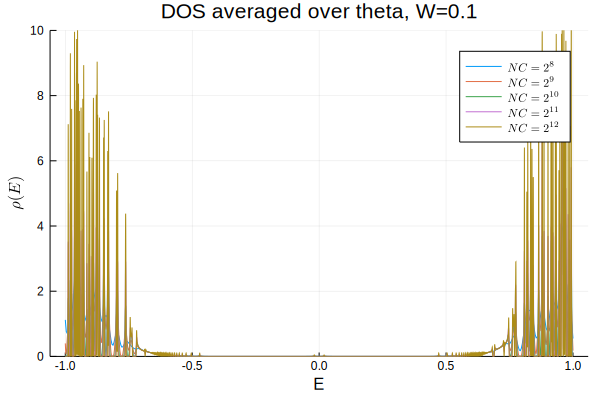

In [10]:
##-- plotting --##

plot(Evalnc[1,:][1],rhoEnc[1][1,:],ylim=(0,10),xlabel="E",ylabel=L"\rho(E)",label=L"NC=2^8",title = "DOS averaged over theta, W=0.1")
plot!(Evalnc[2,:][1],rhoEnc[2][1,:], ylim=(0,10),label=L"NC=2^9")
plot!(Evalnc[3,:][1],rhoEnc[3][1,:], ylim=(0,10),label=L"NC=2^{10}")
plot!(Evalnc[4,:][1],rhoEnc[4][1,:], ylim=(0,10),label=L"NC=2^{11}")
plot!(Evalnc[5,:][1],rhoEnc[5][1,:], ylim=(0,10),label=L"NC=2^{12}") 

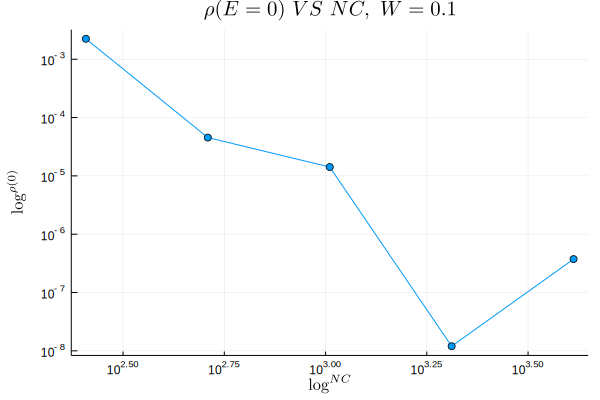

In [12]:
##-- rhoE(0) vs NC --
rhoE0s=zeros(length(NC))
for i in 1:length(NC)
    rhoE0s[i]=rhoEnc[i][1,:][findall(x->x==minimum(abs.(Evalnc[i,:][1])),Evalnc[i,:][1])[1]]
end

plot(NC,rhoE0s, xaxis=:log,yaxis=:log,xlabel=L"\log^{NC}",ylabel=L"\log^{\rho(0)}",label=:false,shape=:circle,title = L"\rho(E=0)\ VS\ NC,\  W=0.1")